In [64]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss


In [65]:
# Set the start and end date for data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'

# Download stock data
stock = yf.download(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


              Open    High     Low   Close  Adj Close     Volume  Log Price  \
Date                                                                          
2023-01-03  14.851  14.996  14.096  14.315  14.305582  401277000   2.660650   
2023-01-04  14.567  14.853  14.241  14.749  14.739295  431324000   2.690517   
2023-01-05  14.491  14.564  14.148  14.265  14.255614  389168000   2.657151   
2023-01-06  14.474  15.010  14.034  14.859  14.849225  405044000   2.697948   
2023-01-09  15.284  16.056  15.141  15.628  15.617718  504231000   2.748406   

            Log Returns  
Date                     
2023-01-03          NaN  
2023-01-04     0.029867  
2023-01-05    -0.033366  
2023-01-06     0.040797  
2023-01-09     0.050458  


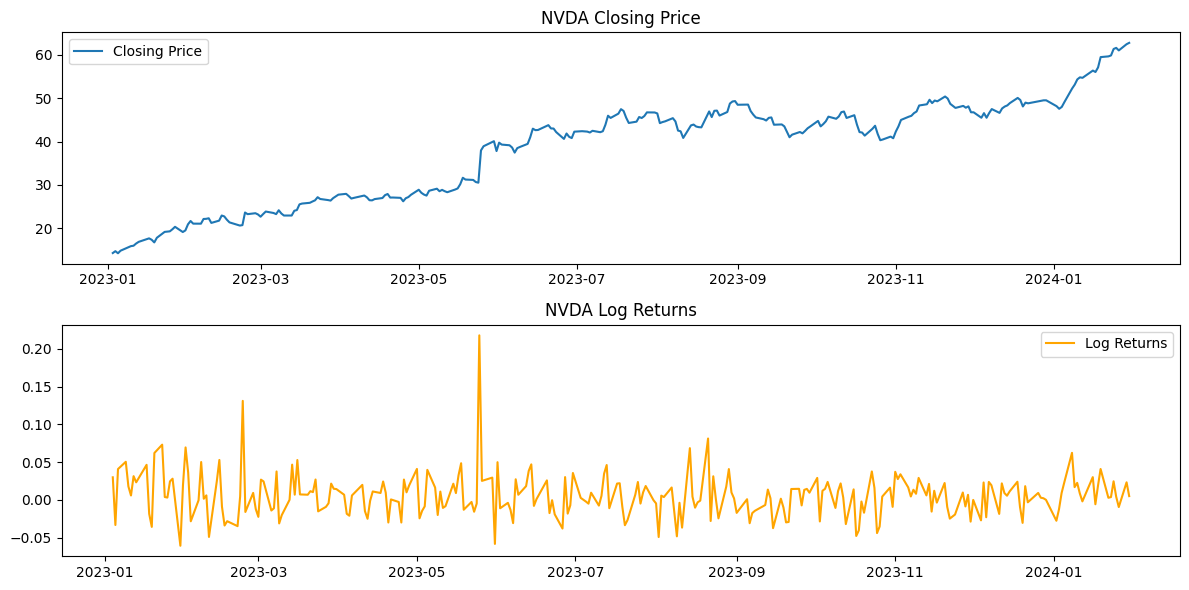

In [66]:
# Apply log transformation to the adjusted close price
stock['Log Price'] = np.log(stock['Adj Close'])

# Calculate log returns as the difference of log prices
stock['Log Returns'] = stock['Log Price'].diff()

# Check if 'Log Returns' is created successfully
print(stock.head())  # Display the first few rows to verify

# Extract the log returns as a numpy array and calculate the length
returns_garch = stock['Log Returns'].dropna().values  # Drop any NaN values before use
time_garch = len(returns_garch)  # Length of time series after dropping NaN values

# Plot the closing prices and log returns for visual inspection
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stock['Adj Close'], label='Closing Price')
plt.title(f'{stock_symbol} Closing Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(stock['Log Returns'], label='Log Returns', color='orange')
plt.title(f'{stock_symbol} Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
# Perform ADF (Augmented Dickey-Fuller) Test to check for stationarity
adf_result = adfuller(returns_garch)
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")
if adf_result[1] < 0.05:
    print("The series is stationary based on the ADF test (p < 0.05).")
else:
    print("The series is non-stationary based on the ADF test (p >= 0.05).")


ADF Test Statistic: -10.650559267741908
p-value: 4.673128508371095e-19
Critical Value 1%: -3.455175292841607
Critical Value 5%: -2.8724677563219485
Critical Value 10%: -2.57259315846006
The series is stationary based on the ADF test (p < 0.05).


In [68]:
# Perform KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test to check for stationarity
kpss_result = kpss(returns_garch, regression='c')
print("KPSS Test Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
for key, value in kpss_result[3].items():
    print(f"Critical Value {key}: {value}")
if kpss_result[1] > 0.05:
    print("The series is stationary based on the KPSS test (p > 0.05).")
else:
    print("The series is non-stationary based on the KPSS test (p <= 0.05).")


KPSS Test Statistic: 0.3091320956170109
p-value: 0.1
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The series is stationary based on the KPSS test (p > 0.05).


C:\Users\56111\AppData\Local\Temp\ipykernel_484188\3520386061.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(returns_garch, regression='c')


In [69]:
def garch(garch_params, *args):
    mu = garch_params[0]
    omega = garch_params[1]
    alpha = garch_params[2]
    beta = garch_params[3]
    mu1 = garch_params[4]
    sig1 = garch_params[5]
    mu2 = garch_params[6]
    sig2 = garch_params[7]
    p = garch_params[8]
    sigma2, F1, F2, v = {}, {}, {}, {}
    GARCH_dens1, GARCH_dens2, GARCH_dens_mix = {}, {}, {}
    sigma2[0] = np.var(returns_garch)
    Likelihood = 0
    for t in range(1, time_garch):
        sigma2[t] = omega + alpha * ((returns_garch[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        F1[t] = returns_garch[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks1
        F2[t] = returns_garch[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks2
        v[t] = sigma2[t]
        GARCH_dens1[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F1[t] / v[t])
        GARCH_dens2[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F2[t] / v[t])
        u = np.random.uniform(0, 1, 1)
        GARCH_dens_mix[t] = (u <= p) * GARCH_dens1[t] + (u > p) * GARCH_dens2[t]
        Likelihood += GARCH_dens_mix[t]

    return Likelihood


In [70]:
def garch_path(garch_params, *args):
    mu = garch_params[0]
    omega = garch_params[1]
    alpha = garch_params[2]
    beta = garch_params[3]
    mu1 = garch_params[4]
    sig1 = garch_params[5]
    mu2 = garch_params[6]
    sig2 = garch_params[7]
    p = garch_params[8]
    sigma2, path = {}, {}
    sigma2[0] = np.var(returns_garch)
    path[0] = np.array([returns_garch[0]])
    for t in range(1, time_garch):
        sigma2[t] = omega + alpha * ((returns_garch[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        u = np.random.uniform(0, 1, 1)
        mixture_shocks = (u <= p) * mixture_shocks1 + (u > p) * mixture_shocks2
        path[t] = mu + np.sqrt(sigma2[t]) * mixture_shocks

    return path, sigma2


In [71]:
# Initial parameter guess
param0 = np.array([np.mean(returns_garch), np.var(returns_garch) / 1600, 0.06, 0.78, 0.04, 0.82, 0.002, 0.92, 0.02])

# Optimize parameters using maximum likelihood estimation
results = minimize(garch, param0, method='BFGS', tol=1e-2, options={'disp': True})
param_star = results.x  # Optimized parameters


         Current function value: -2696.174642
         Iterations: 2
         Function evaluations: 274
         Gradient evaluations: 26


c:\Users\56111\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


RMSE value is: 3.2636282674404558%


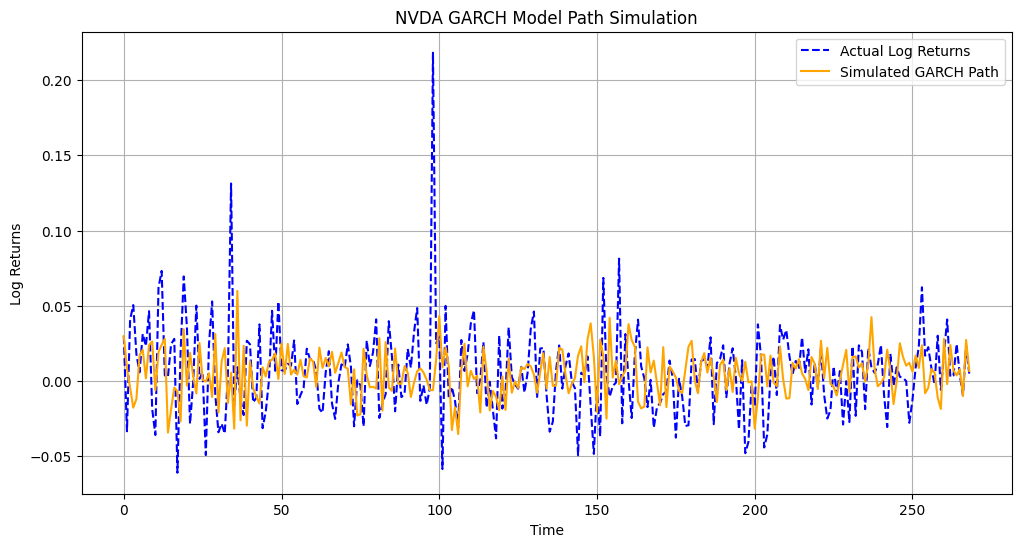

In [72]:
# Simulate the GARCH path using the optimized parameters
simulated_garch_path, garch_variance_path = garch_path(param_star)

# Extract the simulated GARCH path for plotting and RMSE calculation
Y_GARCH = [simulated_garch_path[t][0] for t in range(time_garch)]
GARCH_prediction = list(Y_GARCH)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(GARCH_prediction) - np.array(returns_garch))**2))
print(f'RMSE value is: {RMSE*100}%')

# Visualization of GARCH path
plt.figure(figsize=(12, 6))
plt.plot(returns_garch, label='Actual Log Returns', color='blue', linestyle='--')
plt.plot(list(simulated_garch_path.values()), label='Simulated GARCH Path', color='orange')
plt.title(f'{stock_symbol} GARCH Model Path Simulation')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [73]:
def kalman_filter(observed_data, mean_target, process_variance=1e-5, measurement_variance=0.1):
    num_timesteps = len(observed_data)
    state_estimate = mean_target  # Initial state estimate
    estimate_covariance = 1.0  # Initial covariance estimate

    estimated_states = np.zeros(num_timesteps)
    estimated_variances = np.zeros(num_timesteps)

    for t in range(num_timesteps):
        # Prediction step
        state_estimate = state_estimate  # Mean reversion implies self-predicting
        estimate_covariance += process_variance

        # Kalman gain
        kalman_gain = estimate_covariance / (estimate_covariance + measurement_variance)

        # Update with measurement
        measurement_residual = observed_data[t] - state_estimate
        state_estimate += kalman_gain * measurement_residual
        estimate_covariance = (1 - kalman_gain) * estimate_covariance

        # Store results
        estimated_states[t] = state_estimate
        estimated_variances[t] = estimate_covariance

    return estimated_states, estimated_variances

In [74]:
def kalman_smoother(estimated_states, estimated_variances, process_variance=1e-5):
    num_timesteps = len(estimated_states)
    smoothed_states = np.zeros(num_timesteps)
    smoothed_variances = np.zeros(num_timesteps)

    smoothed_states[-1] = estimated_states[-1]
    smoothed_variances[-1] = estimated_variances[-1]

    for t in range(num_timesteps - 2, -1, -1):
        # Calculate smoother gain
        smoother_gain = estimated_variances[t] / (estimated_variances[t] + process_variance)

        # Update smoothed estimates
        smoothed_states[t] = estimated_states[t] + smoother_gain * (smoothed_states[t + 1] - estimated_states[t])
        smoothed_variances[t] = estimated_variances[t] + smoother_gain * (smoothed_variances[t + 1] - estimated_variances[t])

    return smoothed_states, smoothed_variances

In [75]:
# Run Kalman Filter and Smoother
mean_reversion_target = np.mean(GARCH_prediction)  # Use mean of GARCH prediction
observed_data = returns_garch  # Log returns from GARCH

# Apply Kalman filter
estimated_states, estimated_variances = kalman_filter(observed_data, mean_reversion_target)

# Apply Kalman smoother
smoothed_states, smoothed_variances = kalman_smoother(estimated_states, estimated_variances)


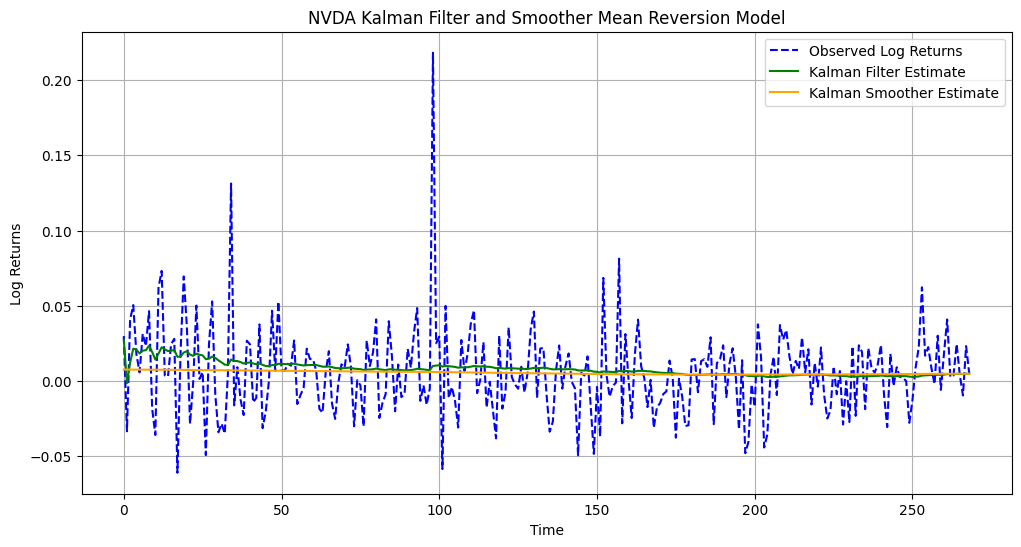

In [76]:
# Time vector for plotting
S = len(observed_data)  # Assuming S represents the number of observations
timevec = np.linspace(1, S, S)

# Title and Plot for Kalman Filter Predictions vs Actual Prices
plt.figure(figsize=(12, 6))
plt.title(f'Kalman Filter Stock Price Prediction: {stock_symbol}')
plt.plot(timevec, estimated_states, 'r', label='Kalman Filter Predictions')
plt.plot(timevec, observed_data, 'b:', label='Actual Prices')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')

# Calculate RMSE
kalman_values = list(estimated_states)
RMSE = np.sqrt(np.mean((np.array(kalman_values) - observed_data) ** 2))
print('RMSE value is: $', RMSE)

plt.show()
